# CNN_Fullscratch
### フルスクラッチでCNNを実装し、CIFER10画像認識タスクに適用する   
### ネットワーク構造：LeNet
### データ：CIFER10 (Keras) 

In [1]:
import numpy as np
import pandas as pd
import time
import gc
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import OrderedDict
from keras.datasets import cifar10
% matplotlib inline
image_num = 50000

(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = cifar10.load_data()

x_train_cifar10 = x_train_cifar10[:image_num]
y_train_cifar10 = y_train_cifar10[:image_num]
y_label_cifar10 = y_train_cifar10
y_train_cifar10 = np.identity(10)[y_train_cifar10]

del x_test_cifar10, y_test_cifar10
gc.collect()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


170500096/170498071 [==============================] - 4s 0us/step


5

### Layer_class

In [3]:
class Layer:
    def __init__(self, params={}):
        if 'input_shape' in params:
            self.in_shape = params['input_shape']
        else:
            self.in_shape = None

        if 'output_shape' in params:
            self.out_shape = params['output_shape']
        else:
            self.out_shape = None

###  MaxPooling_Layer

In [4]:
class MaxPooling(Layer):
    
    def __init__(self, pool_size=4, stride=-1, pad=0, params={}):
        super(MaxPooling, self).__init__(params)
        self.pool_size = pool_size
        self.stride = stride
        self.pad = pad
        self.padding = 'constant'
        self.stride = self.pool_size if self.stride == -1 else stride
        self.max_index = None
        self.input_shape = None 

    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        N, H, W, C = in_shape
        self.out_h = 1 + int((H + 2 * self.pad - self.pool_size) // self.stride)
        self.out_w = 1 + int((W + 2 * self.pad - self.pool_size) // self.stride)
        self.out_shape = (N, self.out_h, self.out_w, C)
        print("Pooling : out {} filter {} stride {} pad {} ".format(self.out_shape, \
                                                                    self.pool_size, \
                                                                    self.stride,\
                                                                    self.pad))
        return self.out_shape

   
    def forward(self, x):
        if self.pad > 0:
            x = np.pad(x, [(0, 0), (self.pad, self.pad), (self.pad, self.pad), (0, 0)], self.padding)
        self.input_shape = x.shape
        N, H, W, C = x.shape
        col = np.array([x[n, h: h + self.pool_size, w: w + self.pool_size, c].flatten() \
                       for c in range(C) \
                       for n in range(N) \
                       for h in range(0, H - self.pool_size + 1, self.stride) \
                       for w in range(0, W - self.pool_size + 1, self.stride)])
        col_max = np.max(col, axis=1)
        self.max_index = np.argmax(col, axis=1)
        return col_max.reshape(C, N, self.out_h, self.out_w).transpose(1, 2, 3, 0)

    def backward(self, dout):
        filter_size = dout.shape[1]
        dout_line = dout.transpose(3, 0, 1, 2).reshape(-1)
        dout = np.zeros([dout_line.shape[0], self.pool_size * self.pool_size])
        for i, max_i in enumerate(self.max_index):
            dout[i, max_i] = dout_line[i]
        in_N, in_H, in_W, in_C = self.input_shape
        img = np.zeros((in_N, in_H + 2 * self.pad, in_W + 2 * self.pad, in_C))
        for i, line in enumerate(dout):
            channel_i, data_i = divmod(i, in_N * self.out_h * self.out_w)
            data_i, square_i = divmod(data_i, self.out_h * self.out_w)
            height_i, width_i = divmod(square_i, self.out_h)
            height_i *= self.stride
            width_i *= self.stride
            img[data_i, height_i: height_i + self.pool_size, width_i:width_i + self.pool_size, channel_i] = \
            line.reshape(self.pool_size, self.pool_size)
        return img[:, self.pad : self.pad + in_H, self.pad : self.pad + in_W, :]

### Convolution_Layer

In [5]:
class Convolution(Layer):
    
    def __init__(self, out_channel=1, filter_size=3, stride=1, pad=0, bias=True, params={}):
        self.filnum = out_channel
        self.out_channel = out_channel
        self.filter_size = filter_size
        self.filsize = filter_size
        self.stride = stride
        self.pad = pad
        self.bias = bias
        self.W = None
        self.b = None
        self.x = None
        self.padding = 'constant'
        self.dW = None
        self.db = None
        self.optimize = None
        if 'lr' in params:
            self.lr = params['lr']
        else:
            self.lr = 0.01
        self.x_2dim = None

    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape  
        N, H, W, in_channel = in_shape
        self.h_num = 1 + ((H + 2 * self.pad - self.filter_size) // self.stride)
        self.w_num = 1 + ((W + 2 * self.pad - self.filter_size) // self.stride)
        self.out_shape = (N, self.h_num, self.w_num, self.out_channel)
        self.W = np.random.randn(self.out_channel, (self.filter_size **2) * in_channel) * 0.1
        self.b = np.random.randn(self.filnum,1)
        self.db = np.zeros((self.filnum,1))
        
        if 'optimizer' in params:
            if params['optimizer'] == 'sgd':
                self.optimize = self.update_sgd
            elif params['optimizer'] == 'adagrad':
                self.h = np.zeros_like(W)
                self.optimize = self.update_adagrad
            else:  # params['optimizer'] == 'adam':
                self.m = np.zeros_like(self.W)
                self.v = np.zeros_like(self.W)
                self.beta1 = 0.9
                self.beta2 = 0.999
                self.optimize = self.update_adam
        else:
            self.optimize = self.update_sgd
            
        print("Convolution : out {}, filter {}, stride {} ".format(self.out_shape, \
                                                                   self.filter_size,\
                                                                   self.stride))
        return self.out_shape
    
    # im2col
    def forward(self, x):
        if self.pad > 0:
            x = np.pad(x, [(0, 0), (self.pad, self.pad), (self.pad, self.pad), (0, 0)], self.padding)
        self.x = x   
        N, H, W, C = x.shape
        self.x_col = np.array([self.x[n, h: h + self.filsize, w: w + self.filsize, :].reshape(-1)\
                              for n in range(N)\
                              for h in range(0, H - self.filsize + 1, self.stride)\
                              for w in range(0, W - self.filsize + 1, self.stride)])
        return  (np.dot(self.W, self.x_col.T) + self.b).transpose(1, 0)\
                .reshape(N, self.h_num, self.w_num, self.filnum)
    # col2im
    def backward(self, dout): 
        N, H, W, C = self.x.shape
        dout1 = dout.reshape(N * self.h_num * self.w_num, self.filnum)                 
        dx0 = np.dot(dout1, self.W)
        dx = np.zeros(self.x.shape)
        for h in range(self.h_num):
            for w in range(self.w_num):
                dx[:, h: h + self.filsize, w: w + self.filsize, :] += dx0.reshape(N, \
                                                                                   self.h_num, \
                                                                                   self.w_num, \
                                                                                   C * (self.filsize**2))\
                                                                                   [:, h, w, :]\
                                                                                   .reshape(N, \
                                                                                            self.filsize, \
                                                                                            self.filsize, \
                                                                                            C)
        self.dW = np.dot(dout1.T, self.x_col)
        self.db = dout1.T.sum(axis=1, keepdims=True)
        return dx[:, self.pad:self.pad + self.in_shape[1], self.pad:self.pad + self.in_shape[2], :]

    def update_sgd(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db

    def update_adagrad(self, lr=0.01):
        self.h += self.dW ** 2
        self.W -= self.lr * self.dW / (np.sqrt(self.h) + 1e-7)
        self.b -= self.lr * self.db

    def update_adam(self, lr=0.01):
        self.m = self.beta1 * self.m + (1 - self.beta1) * self.dW
        self.v = self.beta2 * self.v + (1 - self.beta2) * (self.dW * self.dW)
        m_hat = self.m / (1 - self.beta1)
        v_hat = self.v / (1 - self.beta2)
        self.W -= self.lr * m_hat / (np.sqrt(v_hat) + 1e-8)
        self.b -= self.lr * self.db
    
    def current_weight(self):
        return self.W, self.b
    
    def set_weight(self, w, b):
        self.W = w.reshape(self.W.shape)
        self.b = b.reshape(self.b.shape)

### Flatten_class

In [6]:
class Flatten(Layer):

    def __init__(self, params={}):
        super(Flatten, self).__init__(params)

    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        N, H, W, C = in_shape
        self.out_shape = (N, H * W * C)
        print("Flatten : out {} ".format(self.out_shape))
        return self.out_shape

    def forward(self, x):
        self.input_shape = x.shape
        out = np.array([elem.flatten() for elem in x])
        return out

    def backward(self, dout):
        dout = dout.reshape(self.input_shape)
        return dout

### Dropout_class

In [7]:
class Dropout(Layer):
    def __init__(self, params):
        super(Dropout, self).__init__(params)
        if 'dropout_ratio' in params:
            self.dropout_ratio = params['dropout_ratio']
        else:
            self.dropout_ratio = 0.5
        self.mask = None
    
    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        self.out_shape = self.in_shape
        print("Dropout : ratio {}  ".format(self.dropout_ratio))
        return self.out_shape

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.random_sample(x.shape) > self.dropout_ratio 
            return x * self.mask
        else:
            return x * (1 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

### BatchNormalization_class

In [8]:
class BatchNorm(Layer):
    def __init__(self, params):
        super(BatchNorm, self).__init__(params)
        self.out = None
        self.beta = 0.0
        self.gamma = 1.0
        self.lr = params['lr']
        self.eps = 1e-8

    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        self.out_shape = self.in_shape
        print("BatchNorm : out {} lr {}  ".format(self.out_shape, self.lr))
        return self.out_shape

    def forward(self, x):   
        # step1
        mu = np.mean(x, axis=0)
        # step2
        self.xmu = x - mu
        # step3
        sq = self.xmu ** 2
        # step4
        self.var = np.var(x, axis=0)
        # step5
        self.sqrtvar = np.sqrt(self.var + self.eps)
        # step6
        self.ivar = 1.0 / self.sqrtvar
        # step7
        self.xhat = self.xmu * self.ivar
        # step8
        gammax = self.gamma * self.xhat
        # step9
        out = gammax + self.beta
        return out
 
    def backward(self, dout=1):
        N, D = dout.shape
        
        # step9
        self.d_beta = np.sum(dout, axis=0)
        dgammax = dout  
        # step8
        self.d_gamma = np.sum(dgammax * self.xhat, axis=0)
        dxhat = dgammax * self.gamma
        # step7
        divar = np.sum(dxhat * self.xmu, axis=0)
        dxmu1 = dxhat * self.ivar
        # step6
        dsqrtvar = -1. / (self.sqrtvar ** 2) * divar
        # step5
        dvar = 0.5 * 1. / np.sqrt(self.var + self.eps) * dsqrtvar
        # step4
        dsq = 1. / N * np.ones((N, D)) * dvar
        # step3
        dxmu2 = 2 * self.xmu * dsq
        # step2
        dx1 = (dxmu1 + dxmu2)
        dmu = -1 * np.sum(dxmu1 + dxmu2, axis=0)
        # step1
        dx2 = 1. / N * np.ones((N, D)) * dmu
        # step0
        dx = dx1 + dx2
        return dx
   
    def optimize(self):
        self.gamma -= self.lr * self.d_gamma
        self.beta -= self.lr * self.d_beta

### Activation_class

In [9]:
class Activation(Layer):
    
    def __init__(self, params):
        super(Activation, self).__init__(params)
        self.out = None
        self.mask = None
        if 'activation' in params:
            if params['activation'] == 'tanh':
                self.forward = self.forward_tanh
                self.backward = self.backward_tanh
            elif params['activation'] == 'sigmoid':
                self.forward = self.forward_sigmoid
                self.backward = self.backward_sigmoid
            else:  # params['activation'] == 'relu':
                self.forward = self.forward_relu
                self.backward = self.backward_relu
        else:
            params['activation'] = 'relu'
            self.forward = self.forward_relu
            self.backward = self.backward_relu

    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        self.out_shape = self.in_shape
        print("Activation : out {}   func : {} ".format(self.out_shape, params['activation']))
        return self.out_shape

    
    # ReLU
    def forward_relu(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
  
    def backward_relu(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

    # tanh
    def forward_tanh(self, x):
        out = np.tanh(x)
        self.out = out
        return out

    def backward_tanh(self, dout):
        dx = dout * (1 - np.tanh(dout) ** 2)
        return dx

    # sigmoid
    def forward_sigmoid(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward_sigmoid(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

### Affine_class

In [10]:
class Affine(Layer):
    
    def __init__(self, unit_size=100, params={}):
        super(Affine, self).__init__(params)
        self.W = None
        self.b = None
        self.x = None
        self.unit_size = unit_size
        self.dW = None
        self.db = None
        if 'lr' in params:
            self.lr = params['lr']
        else:
            self.lr = 0.01
            
    def initialize(self, in_shape, params={}):
        self.in_shape = in_shape
        N, F = in_shape
        self.out_shape = (N, self.unit_size)

        # initialize
        self.W = np.random.randn(F, self.unit_size)
        self.b = np.zeros([1, self.unit_size])
        self.W *= 0.01

        # optimizer
        if 'optimizer' in params:
            if params['optimizer'] == 'sgd':
                self.optimize = self.update_sgd
            elif params['optimizer'] == 'adagrad':
                self.h = np.zeros_like(self.W)
                self.optimize = self.update_adagrad
            else:  # params['optimizer'] == 'adam':
                self.m = np.zeros_like(self.W)
                self.v = np.zeros_like(self.W)
                self.beta1 = 0.9
                self.beta2 = 0.999
                self.optimize = self.update_adam
        else:
            params['optimizer'] = 'adam'
            self.optimize = self.update_adam
        print("Affine : out {} optimizer {} unit {} ".format(self.out_shape, params['optimizer'],\
                                                             self.unit_size))
        return self.out_shape
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout=1):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx
    
    def update_sgd(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db
        
    def update_adagrad(self, lr=0.01):
        self.h += self.dW ** 2
        self.W -= self.lr * self.dW / (np.sqrt(self.h) + 1e-7)
        self.b -= self.lr * self.db
     
    def update_adam(self, lr=0.01):
        self.m = self.beta1 * self.m + (1 - self.beta1) * self.dW
        self.v = self.beta2 * self.v + (1 - self.beta2) * (self.dW * self.dW)
        m_hat = self.m / (1 - self.beta1)
        v_hat = self.v / (1 - self.beta2)
        self.W -= self.lr * m_hat / (np.sqrt(v_hat) + 1e-8)
        self.b -= self.lr * self.db
    
    def current_weight(self):
        return self.W, self.b
    
    def set_weight(self, w, b):
        self.W = w.reshape(self.W.shape)
        self.b = b.reshape(self.b.shape)

### SoftmaxWithLoss_class

In [11]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

def cross_entropy_error(y, y_pred):
    data_size = y.shape[0]
    cross_entorpy = -np.sum(y * np.log(y_pred + 1e-7))
    error = cross_entorpy / data_size
    return error

In [12]:
class SoftmaxWithLoss(Layer):
    def __init__(self, params={}):
        super(SoftmaxWithLoss, self).__init__(params)
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

### LeNetLayers_class

In [13]:
class LeNetLayers:
    def __init__(self, params):
        unit_size_list = [params['input_size']]
        unit_size_list.extend(params['hidden_layer_list'])
        unit_size_list.append(params['output_size'])

        self.params = {}
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(6, 5, 1, 2) 
        self.layers['Active1'] = Activation(params)
        self.layers['Pool1'] = MaxPooling(2, 2, 0, params)
        self.layers['Conv2'] = Convolution(16, 5, 1, 2)
        self.layers['Active2'] = Activation(params)
        self.layers['Pool2'] = MaxPooling(2, 2, 0, params)
        self.layers['Flatten'] = Flatten(params)
        self.layers['Affine1'] = Affine(120, params)
        self.layers['Dropout1'] = Dropout(params)
        self.layers['BatchNorm1'] = BatchNorm(params)
        self.layers['Active3'] = Activation(params)
        self.layers['Affine2'] = Affine(84, params)
        self.layers['Dropout2'] = Dropout(params)
        self.layers['BatchNorm2'] = BatchNorm(params)
        self.layers['Active4'] = Activation(params)
        self.layers['Affine3'] = Affine(params['output_size'], params)
     
    def initialize(self, x, y, params):
        in_shape = x.shape 
        print("Input_shape:",x.shape)
        out_shape = y.shape 
        print('###########' * 5)
        for i, layer_ in enumerate(self.layers.values()):
            print(" Layer {}".format(i))
            in_shape = layer_.initialize(in_shape, params)
            print('###########' * 5)

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def accuracy(self, x, t):
        y_pred = self.predict(x)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(t, axis=1)
        data_size = x.shape[0]
        correct_count = np.sum([y_true == y_pred])
        score = correct_count / data_size * 100
        return round(score, 2)
 
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
 
    def optimize(self, x, t):
        # forward
        self.loss(x, t)   
        # backward
        dout = self.lastLayer.backward(1)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)    
        for layer in self.layers.values():         
            if hasattr(layer, "optimize"):
                layer.optimize()
    
    def collect_weight(self):
        weight_list=[]
        for layer in self.layers.values():
            if hasattr(layer, "current_weight"):
                w, b = layer.current_weight()
                weight_list.append(w.flatten())
                weight_list.append(b.flatten())
        return pd.DataFrame(weight_list) 
    
    def reuse_weight(self, w):
        i = 0
        for layer in self.layers.values():
            if hasattr(layer, "set_weight"):
                layer.set_weight(w[i][~np.isnan(w[i])], \
                                 w[i+1][~np.isnan(w[i+1])])
                i += 2

### CNN_class

In [14]:
class CNN:
    def __init__(self, init='gauss', epochs=10, lr=0.05, lam=0.01,
                 batch_mode='mini', activation='relu',
                 batch_size=32, hidden_layer_list=[20,20], optimizer='sgd',
                 batch_norm=False, dropout_ratio=0.3, save_weight=None,
                 use_weight=None):
        
        """ ハイパーパラメータ
        init: 初期化手法
            'he'
            'gauss' 
            'xavier'
        lr : 学習率
        lam : 正則化項の率
        batch_mode: 学習モード
            'batch'
            'mini'
            'online'
        hidden_layer_list : 隠れ層のリスト、層のユニットをリストで入力
        optimizer : 勾配更新手法
            'sgd'
            'adam'
            'adagrad'
        act_func: 活性化関数
            'relu'
            'tanh'
            'sigmoid'
        """
        self.params = {}
        self.params['epochs'] = epochs
        self.params['init'] = init
        self.params['lr'] = lr
        self.params['lam'] = lam  
        self.params['batch_mode'] = batch_mode  
        self.params['batch_size'] = batch_size
        self.params['hidden_layer_list'] = hidden_layer_list
        self.params['optimizer'] = optimizer
        self.params['batch_norm'] = batch_norm
        self.params['dropout_ratio'] = dropout_ratio
        self.params['activation'] = activation
        self.params['save_weight'] = save_weight
        self.params['use_weight'] = use_weight
        

    def train(self, X, y, params={}):
        for key in params:
            self.params[key] = params[key]

        X = X / 255.0
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.2, random_state=0)

        self.params['data_size'] = X_train.shape[0]
        self.params['input_size'] = X_train.shape[1]
        self.params['output_size'] = y_train.shape[1]

        past_train_costs = []
        past_test_costs = []
        past_train_accuracy = []
        past_test_accuracy = []

        N, H, W, C = X_train.shape

        # 学習モード
        if self.params['batch_mode'] == 'batch':
            self.params['batch_size'] = self.params['data_size']
        elif self.params['batch_mode'] == 'online':
            self.params['batch_size'] = 1
        
        # 隠れ層やレイヤーインスタンス生成
        in_shape = (self.params['batch_size'], H, W, C)
        self.params['layer'] = LeNetLayers(self.params)
        # 入出力サイズ
        self.params['layer'].initialize(X_train[:self.params['batch_size']],\
                                        y_train[:self.params['batch_size']],\
                                        self.params)
        # 学習済みweightファイルから値を取得
        if self.params['use_weight'] is not None:
            past_weight = pd.read_csv(self.params['use_weight'])
            self.params['layer'].reuse_weight(np.array(past_weight))

        iteration = int(X_train.shape[0] / self.params['batch_size'])
        choice_list = list(range(X_train.shape[0]))
        
        for i in range(self.params['epochs']*iteration):
            start = i % iteration * self.params['batch_size']
            end = start + self.params['batch_size']
            X_batch, y_batch = X_train[choice_list[start:end]], y_train[choice_list[start:end]]
            
            # 勾配を求め値を更新  
            self.params['layer'].optimize(X_batch, y_batch)
            # 正答率とコストを算出して保存
            if i==0 or (i%iteration is 0):
                # 正答率とコストを算出して保存
                train_acc = self.params['layer'].accuracy(X_train, y_train)
                past_train_accuracy.append(train_acc)
                test_acc = self.params['layer'].accuracy(X_test, y_test)
                past_test_accuracy.append(test_acc)
                train_loss = self.params['layer'].loss(X_train, y_train)
                past_train_costs.append(train_loss)
                test_loss = self.params['layer'].loss(X_test, y_test)
                past_test_costs.append(test_loss)
                print("epoch:{} train_acc:{}, train_loss:{}, test_acc:{}, test_loss:{}"\
                      .format(i//iteration, train_acc, train_loss, test_acc, test_loss))
                #wegiht保存  
                if self.params['save_weight'] is not None:
                    weights = self.params['layer'].collect_weight()
                    weights.to_csv(self.params['save_weight']\
                                   + '_' + str(i//iteration)\
                                   + '_' + str(round(test_acc, 1))\
                                   + '_' + str(round(test_loss, 2))\
                                   + '.csv', index=False)

            if i%iteration is 9:
                random.shuffle(choice_list)
        return past_train_accuracy, past_test_accuracy, past_train_costs, past_test_costs


    def predict(self, X, probability=False):
        predict = self.params['layer'].predict(X, train_flg=False)
        predict_proba = softmax(predict)
        if probability is True:
            return predict_proba
        else:
            return np.argmax(predict_proba, axis=1)

### 学習

Input_shape: (32, 32, 32, 3)
#######################################################
 Layer 0
Convolution : out (32, 32, 32, 6), filter 5, stride 1 
#######################################################
 Layer 1
Activation : out (32, 32, 32, 6)   func : relu 
#######################################################
 Layer 2
Pooling : out (32, 16, 16, 6) filter 2 stride 2 pad 0 
#######################################################
 Layer 3
Convolution : out (32, 16, 16, 16), filter 5, stride 1 
#######################################################
 Layer 4
Activation : out (32, 16, 16, 16)   func : relu 
#######################################################
 Layer 5
Pooling : out (32, 8, 8, 16) filter 2 stride 2 pad 0 
#######################################################
 Layer 6
Flatten : out (32, 1024) 
#######################################################
 Layer 7
Affine : out (32, 120) optimizer adam unit 120 
#######################################################
 Lay

Text(0.5,0,'iteration[epoch]')

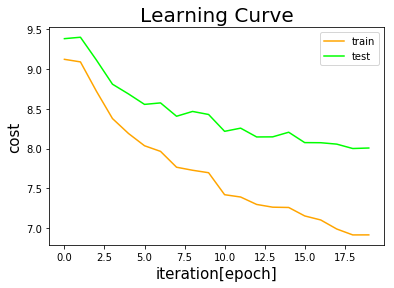

In [15]:
model = CNN(epochs=20, optimizer='adam',batch_norm=True)
# weightファイルを読み込み途中から学習再開
params = {'batch_mode' : 'mini',
          'lr': 0.01,
          'use_weight':'weights_6_55.2_9.29.csv',
          'save_weight':'weights'
         }

past_train_accuracy, past_test_accuracy, past_train_costs, past_test_costs = model.train(x_train_cifar10,\
                                                                                         y_train_cifar10.\
                                                                                         reshape(image_num, 10),\
                                                                                         params)

plt.figure(figsize=(6,4))
plt.plot(past_train_costs, color='orange', label='train')
plt.plot(past_test_costs, color='lime', label='test')
plt.ylabel("cost", fontsize=15)
print("last train cost is {}".format(past_train_costs[-1]))
print("last test cost is {}".format(past_test_costs[-1]))
plt.legend()
plt.title('Learning Curve', fontsize=20)
plt.xlabel("iteration[epoch]", fontsize=15)

#### 今回は試験的にシンプルなモデル LeNet（Convolutionレイヤーが２つ）を採用した  
#### 更なる性能向上にはVGGやinceptionのようにレイヤー数、ユニット数の増加が必要と考えられる